In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

In [182]:
DATASET_PATH = 'course_project_train.csv'
TEST_PART_PATH = 'test.csv'

In [183]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - время на текущей работе
* Tax Liens - налоговый залог
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - время кредитной истории
* Maximum Open Credit - максимально взятый кредит
* Number of Credit Problems - количество проблемных кредитов
* Months since last delinquent - месяцев с полседнего нарушения
* Bankruptcies - банкротство
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный платёж
* Credit Score - кредитный рейтинг
* Credit Default - невыплата кредита

In [184]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [185]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop('Credit Default').tolist()
NUM_FEATURE_NAMES = df.select_dtypes(include=['float64', 'int64'])
NUM_FEATURE_NAMES = NUM_FEATURE_NAMES.columns.drop('Credit Default').tolist()
CAT_FEATURE_NAMES = df.select_dtypes(include=['object'])
CAT_FEATURE_NAMES = CAT_FEATURE_NAMES.columns.tolist()
NaN_FEATURE_NAMES = df.loc[:, df.isnull().any()].copy()
NaN_FEATURE_NAMES = NaN_FEATURE_NAMES.columns.tolist()
Non_nan_FEATURE_NAMES = [feature for feature in BASE_FEATURE_NAMES if feature not in NaN_FEATURE_NAMES]
NUM_nan_FEATURE_NAMES = [feature for feature in NUM_FEATURE_NAMES if feature not in NaN_FEATURE_NAMES]

In [186]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AD04D94760>,
      dtype=object)

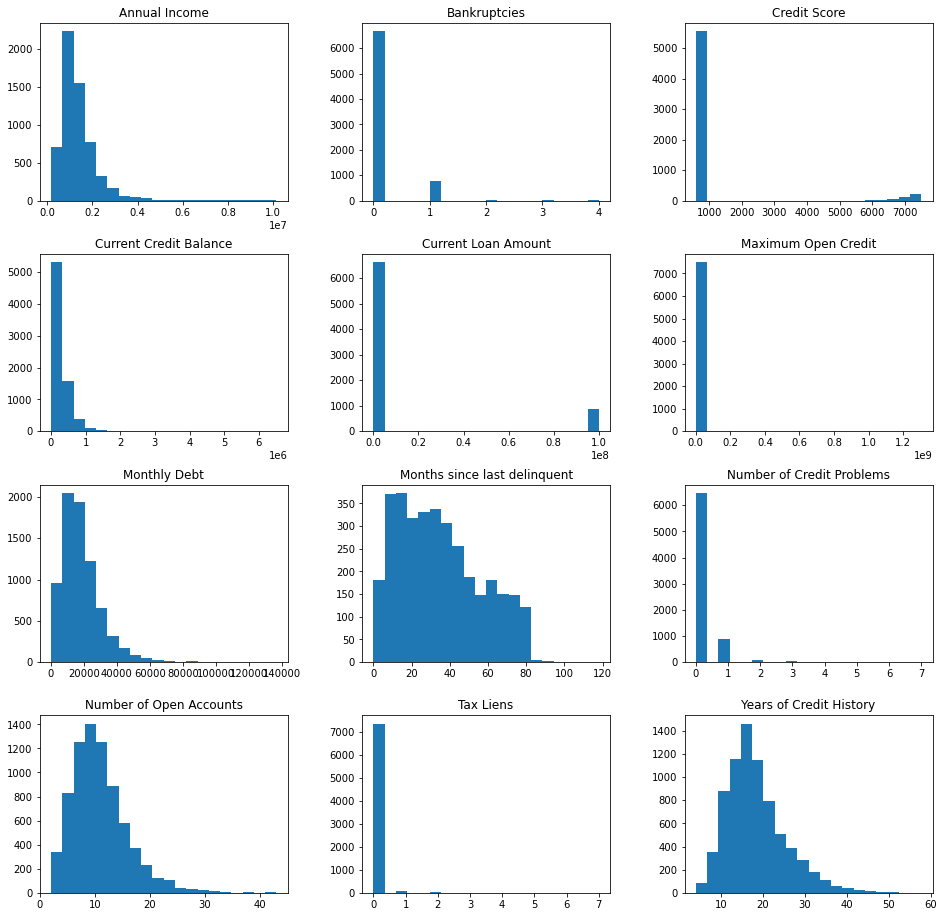

In [187]:
df[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False)

In [188]:
#убираем выбросы, заменяем наны
df.loc[df['Credit Score'] > 5000, 'Credit Score'] = df['Credit Score']/10
df.loc[df['Credit Score'].isna() & (df['Credit Default'] == 1), 'Credit Score'] = 600.000000
df.loc[df['Credit Score'].isna() & (df['Credit Default'] == 0), 'Credit Score'] = 740.000000
df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = 0
df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Monthly Debt'] * 80
df.loc[df['Years in current job'].isna(), 'Years in current job'] = "10+ years"
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df['Maximum Open Credit'] - df['Current Credit Balance']
df.loc[df['Bankruptcies'] > 1, 'Bankruptcies'] = 1
df.loc[df['Tax Liens'] > 1, 'Tax Liens'] = 1
df.loc[df['Number of Credit Problems'] > 1, 'Number of Credit Problems'] = 1

In [189]:
df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [190]:
PREPARED_DATASET_PATH = 'curs2_prepared.csv'
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [191]:
df_train = pd.read_csv(PREP_DATASET_PATH)

In [192]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,638574.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,874045.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,0.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,741.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,0.0,0.0,buy a car,Short Term,1301108.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,2969440.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,0.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,740.0,0


In [193]:
X = df_train.drop(columns=[TARGET_NAME])
y = df_train[TARGET_NAME]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

X_train = df_train.drop(columns=[TARGET_NAME])
y_train = df_train[TARGET_NAME]

In [194]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

In [195]:
df = df_balanced.copy()

In [196]:
X = df.drop(columns=[TARGET_NAME])
y = df[TARGET_NAME]

In [197]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [198]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

1.3065902578796562

In [199]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [200]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [201]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3648
           1       0.83      0.87      0.85      2792

    accuracy                           0.87      6440
   macro avg       0.86      0.87      0.86      6440
weighted avg       0.87      0.87      0.87      6440

TEST

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1739
           1       0.72      0.75      0.73      1434

    accuracy                           0.75      3173
   macro avg       0.75      0.75      0.75      3173
weighted avg       0.75      0.75      0.75      3173

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1314   425
1                359  1075


In [202]:
df_test = pd.read_csv(TEST_PART_PATH)

In [203]:
#Подготавливаем тестовые данные
df_test.loc[df_test['Credit Score'] > 5000, 'Credit Score'] = df_test['Credit Score']/10
df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = 0
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] = df_test['Monthly Debt'] * 80
df_test.loc[df_test['Years in current job'].isna(), 'Years in current job'] = "10+ years"
df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
df_test.loc[df_test['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df_test['Maximum Open Credit'] - df_test['Current Credit Balance']
df_test.loc[df_test['Bankruptcies'] > 1, 'Bankruptcies'] = 1
df_test.loc[df_test['Tax Liens'] > 1, 'Tax Liens'] = 1
df_test.loc[df_test['Number of Credit Problems'] > 1, 'Number of Credit Problems'] = 1

In [204]:
test_pred = model_catb.predict(df_test)
test_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [205]:
submit = pd.read_csv('sample_submission.csv')
feature_names = ['Id']
prediction = submit[feature_names]
prediction['Credit Default'] = test_pred
prediction

,Id,Credit Default
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,0


In [206]:
# Сохраняем результаты 
prediction.to_csv('catb_submit.csv', index=False)